In [1]:
from qiskit.circuit import QuantumCircuit
from qiskit import transpile, assemble, Aer, IBMQ, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from sympy import Matrix
import matplotlib.pyplot as plt
from qiskit.circuit.instruction import Instruction
from qiskit.circuit.quantumcircuitdata import QuantumCircuitData, CircuitInstruction
from qiskit.circuit.classicalregister import ClassicalRegister, Clbit
from qiskit.circuit.quantumregister import QuantumRegister, Qubit
from qiskit.circuit.library.standard_gates.h import *
import qiskit
import numpy as np
from circuit_remapper import *
from components.layer import *
from qiskit.quantum_info import partial_trace
import warnings

warnings.filterwarnings("ignore")
sim = Aer.get_backend('aer_simulator')

C:\Users\anura\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\anura\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\anura\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def measure_sim(qc, samples=20000):
    backend = Aer.get_backend('statevector_simulator')
    circuit = transpile(qc, backend=backend)
    #     print(circuit)
    job = execute(qc, backend, shots=samples)
    counts = job.result().get_counts()
#     print("Job result: ", job.result())
    return counts

##### TEST for TOPOLOGY

In [3]:
# Write a q_map as dictionary
# q_map = qmap()
# q_map.create_qmap(3, [2, 3, 3],"sys")
# e_map = q_map.create_emap()
# print(q_map)
# print(e_map)

circuit_topo = Topology()
circuit_topo.create_qmap(3, [2, 3, 3],"sys")
circuit_topo.qmap, circuit_topo.emap

({'sys0': [Qubit(QuantumRegister(2, 'sys0'), 0),
   Qubit(QuantumRegister(2, 'sys0'), 1)],
  'sys1': [Qubit(QuantumRegister(3, 'sys1'), 0),
   Qubit(QuantumRegister(3, 'sys1'), 1),
   Qubit(QuantumRegister(3, 'sys1'), 2)],
  'sys2': [Qubit(QuantumRegister(3, 'sys2'), 0),
   Qubit(QuantumRegister(3, 'sys2'), 1),
   Qubit(QuantumRegister(3, 'sys2'), 2)]},
 {'sys0': Qubit(QuantumRegister(1, 'com_sys0'), 0),
  'sys1': Qubit(QuantumRegister(1, 'com_sys1'), 0),
  'sys2': Qubit(QuantumRegister(1, 'com_sys2'), 0)})

###### Test for topology class methods

In [4]:
print("Total Number of Qubits in Topology : ", circuit_topo.num_qubits())
print("Total Number of QPUs in Topology: ", circuit_topo.num_hosts())

Qubit1 = circuit_topo.qmap["sys1"][2]
Qubit2 = circuit_topo.qmap["sys2"][1]
print("{} and {} are adjacent".format(Qubit1, Qubit2) 
      if circuit_topo.are_adjacent(Qubit1, Qubit2) else 
      "{} and {} are not adjacent".format(Qubit1, Qubit2))

for qubit in circuit_topo.qubits:
    print("Qubit: {} --------- Host: {}".format(qubit, circuit_topo.get_host(qubit)))

Total Number of Qubits in Topology :  8
Total Number of QPUs in Topology:  3
Qubit(QuantumRegister(3, 'sys1'), 2) and Qubit(QuantumRegister(3, 'sys2'), 1) are not adjacent
Qubit: Qubit(QuantumRegister(2, 'sys0'), 0) --------- Host: sys0
Qubit: Qubit(QuantumRegister(2, 'sys0'), 1) --------- Host: sys0
Qubit: Qubit(QuantumRegister(3, 'sys1'), 0) --------- Host: sys1
Qubit: Qubit(QuantumRegister(3, 'sys1'), 1) --------- Host: sys1
Qubit: Qubit(QuantumRegister(3, 'sys1'), 2) --------- Host: sys1
Qubit: Qubit(QuantumRegister(3, 'sys2'), 0) --------- Host: sys2
Qubit: Qubit(QuantumRegister(3, 'sys2'), 1) --------- Host: sys2
Qubit: Qubit(QuantumRegister(3, 'sys2'), 2) --------- Host: sys2


##### Test for circuit remapper defined in layer.py

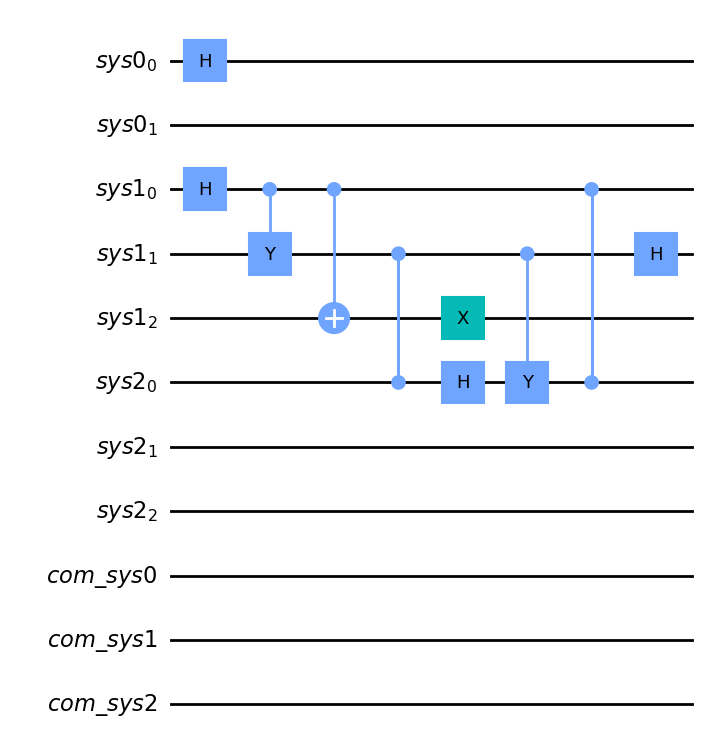

In [5]:
qregs = circuit_topo.get_regs()
qc = QuantumCircuit(*qregs)
qc.h(0),qc.h(2)
qc.cy(2,3)
qc.cx(2,4)
qc.cz(3,5)
qc.h(5)
qc.cy(3,5)
qc.cz(2,5)
qc.x(4)
qc.h(3)
qc.draw(output='mpl')

In [6]:
circ_object = CircuitRemapper(circuit_topo)
layers_here = circ_object._circuit_to_layers(qc)
layers_here

[[CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'sys0'), 0),), clbits=()),
  CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'sys1'), 0),), clbits=())],
 [CircuitInstruction(operation=Instruction(name='cy', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'sys1'), 0), Qubit(QuantumRegister(3, 'sys1'), 1)), clbits=())],
 [CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'sys1'), 0), Qubit(QuantumRegister(3, 'sys1'), 2)), clbits=()),
  CircuitInstruction(operation=Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'sys1'), 1), Qubit(QuantumRegister(3, 'sys2'), 0)), clbits=())],
 [CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegi

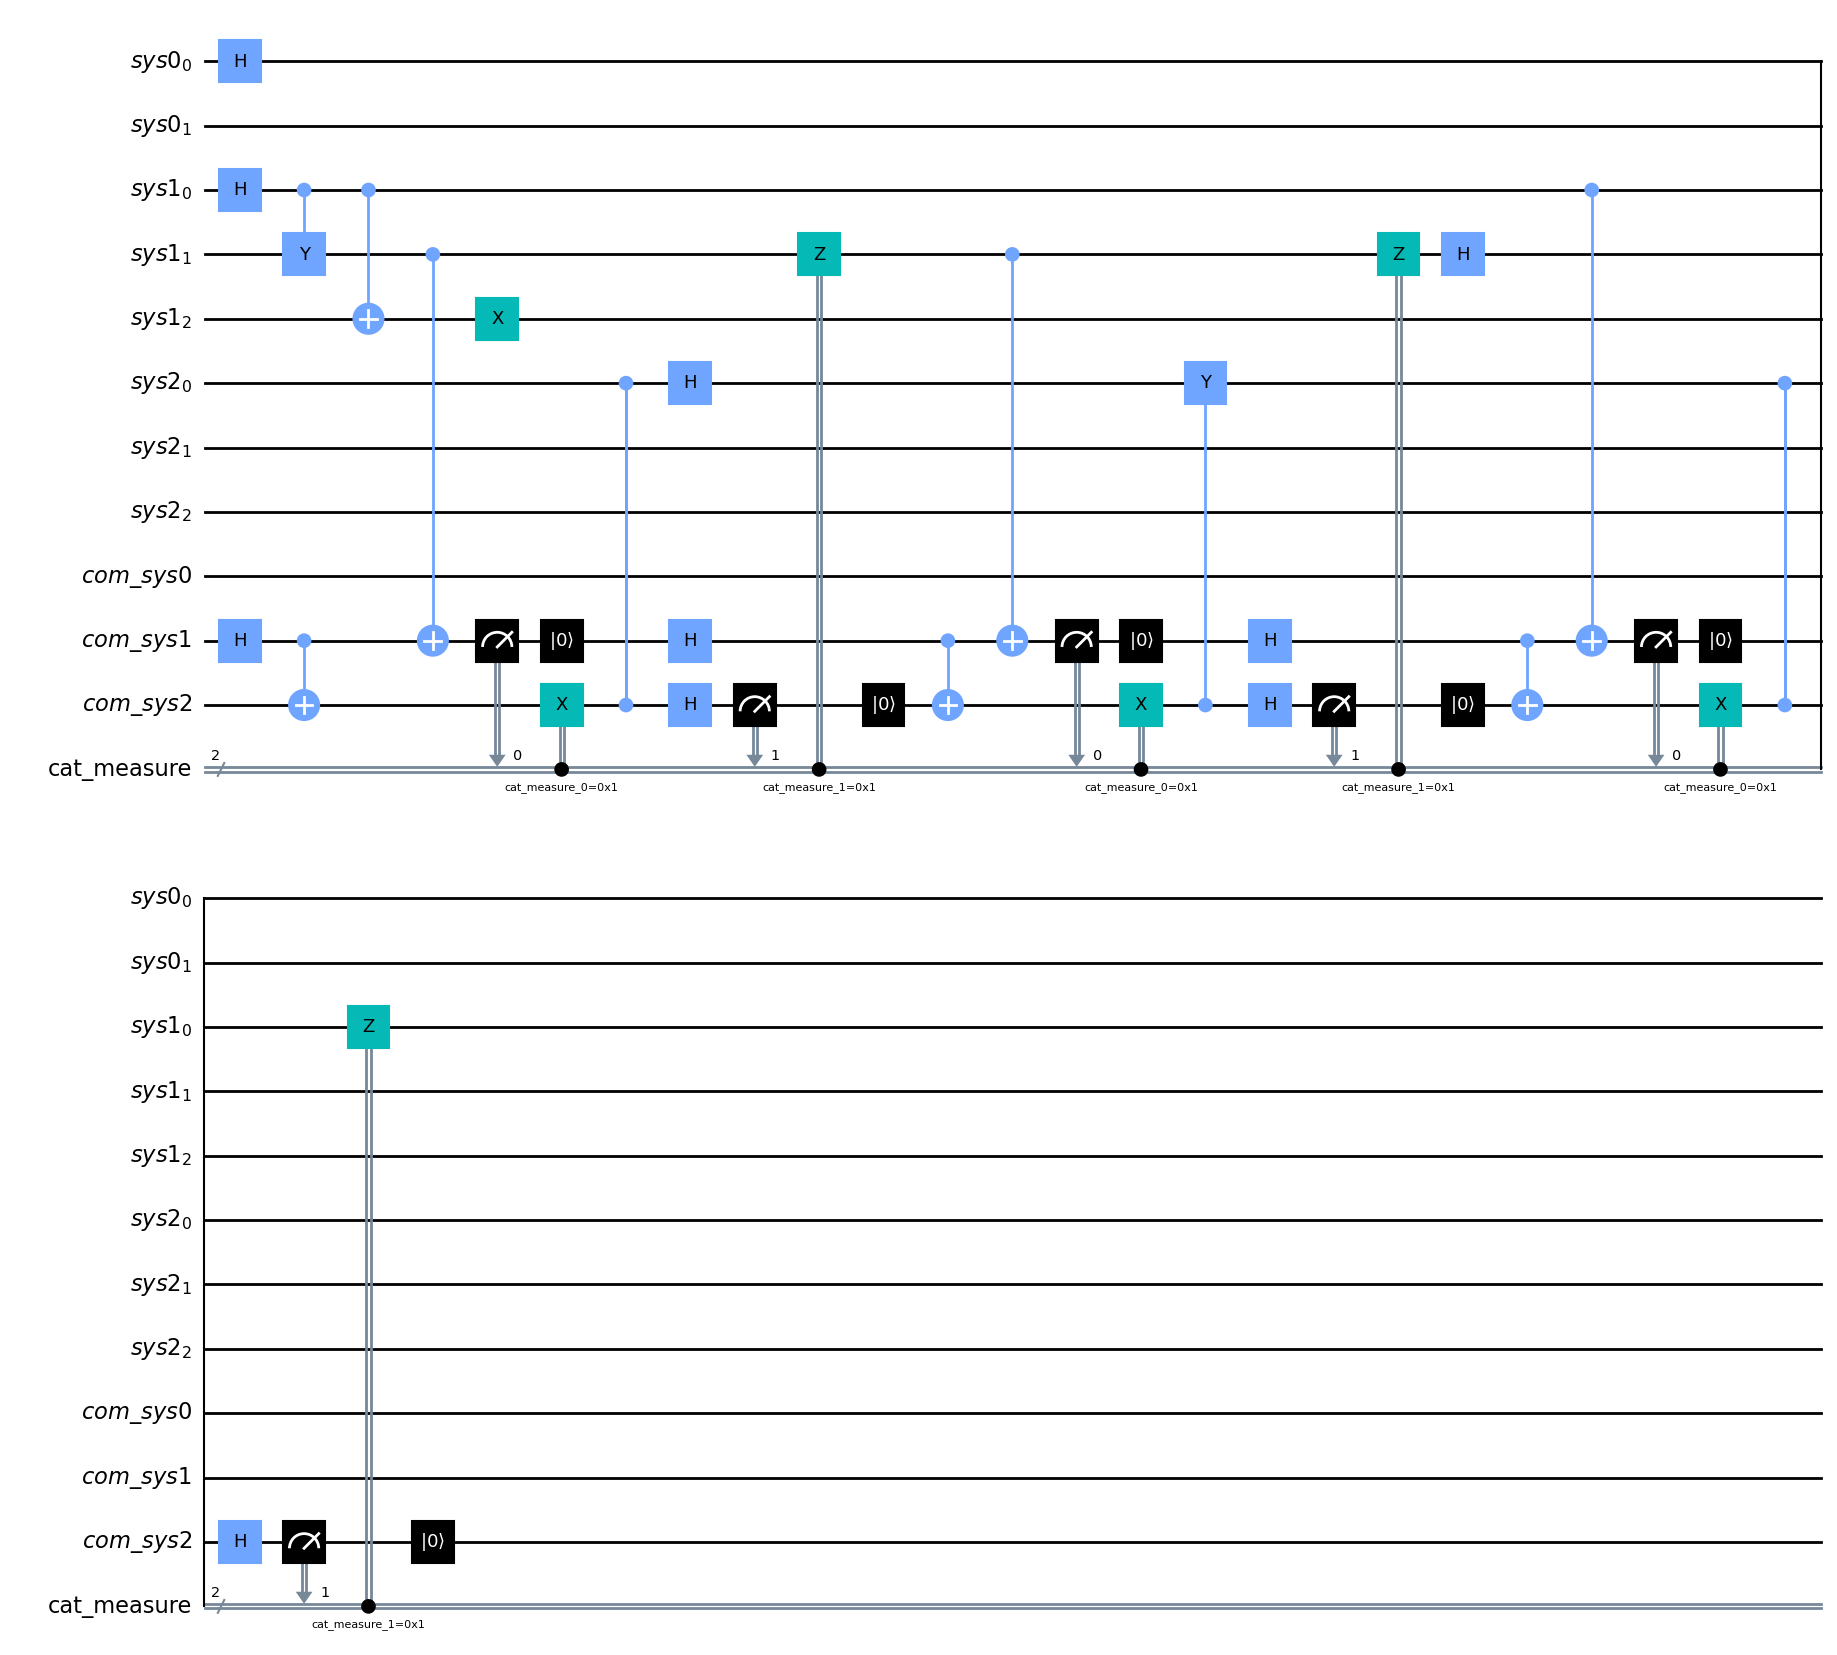

In [7]:
dist_circ = circ_object.remap_circuit(qc)
dist_circ.draw(output='mpl')

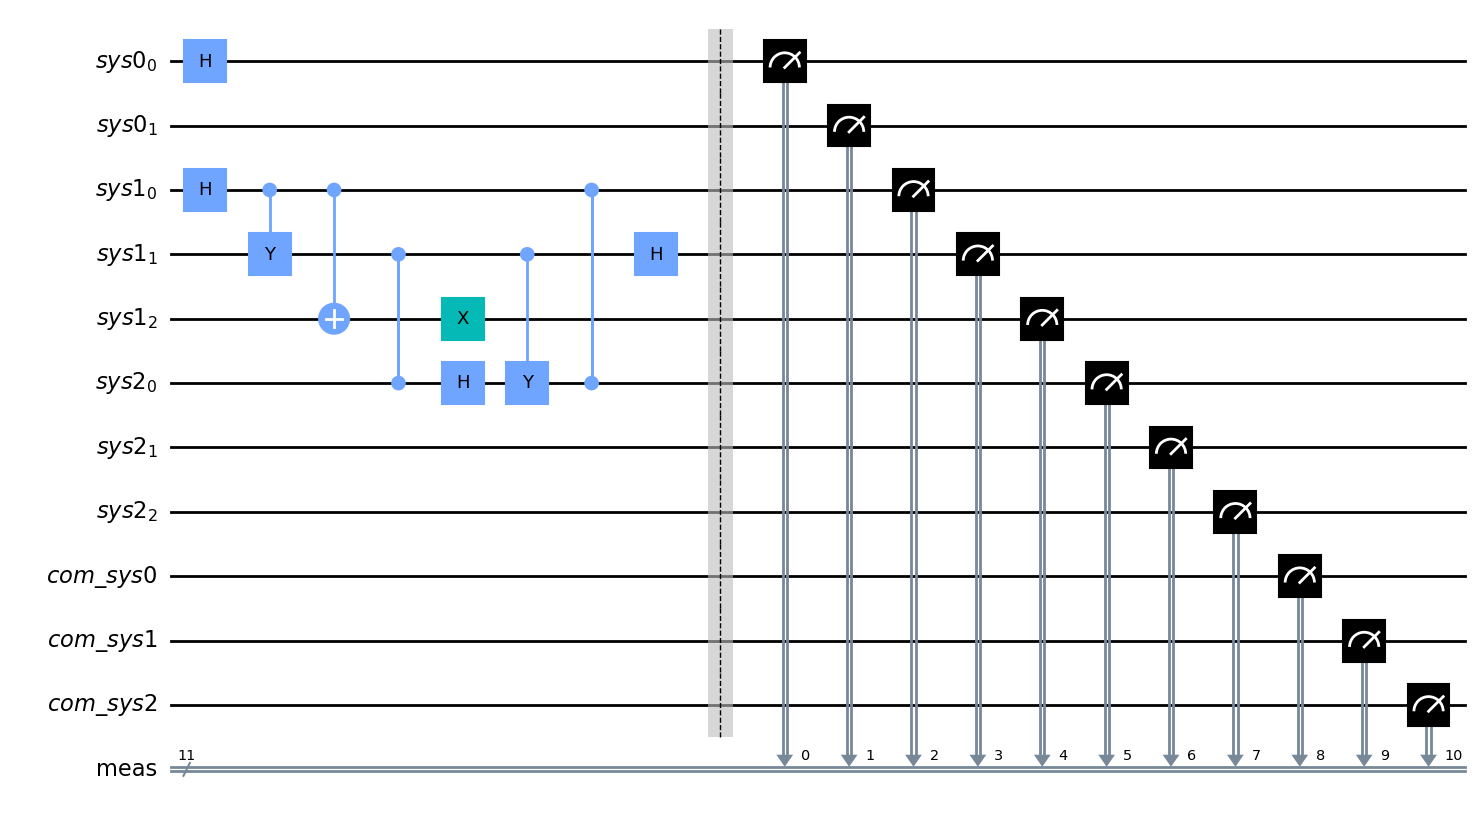

In [8]:
qc.measure_all()
qc.draw('mpl')

{'00000111000': 1249, '00000110001': 1260, '00000010000': 1287, '00000011000': 1290, '00000100100': 1256, '00000001101': 1278, '00000000100': 1272, '00000101101': 1233, '00000000101': 1264, '00000001100': 1278, '00000100101': 1221, '00000010001': 1208, '00000111001': 1226, '00000101100': 1217, '00000011001': 1221, '00000110000': 1240}


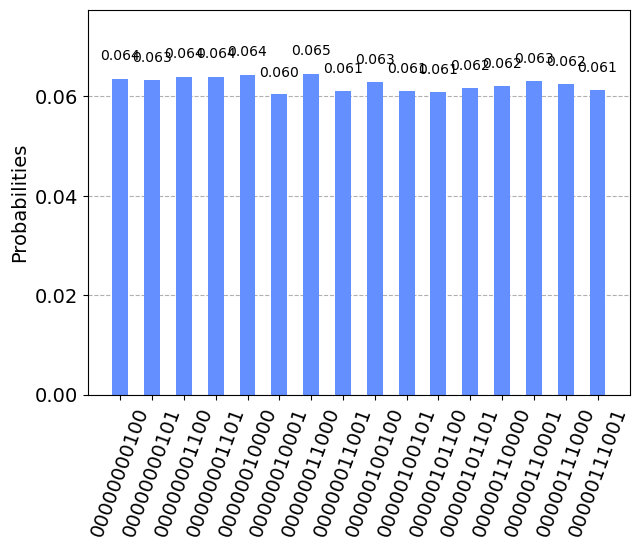

In [9]:
sim_count = measure_sim(qc=qc)
print(sim_count)
plot_histogram(sim_count)

In [ ]:
CircuitRemapper.do_measure_ready(dist_circ, circuit_topo)
dist_circ.draw(output='mpl')

In [ ]:
dist_sim_count = measure_sim(qc=dist_circ)
n_q = circuit_topo.num_qubits()
sim_dict = CircuitRemapper.collate_measurements(dist_sim_count, n_q)
        
print(sim_dict)
plot_histogram(sim_dict) 

In [2]:
## Assert same binary string values in simulation count dictionary to determine equivalence
assert sim_dict.keys() == sim_count.keys()

NameError: name 'sim_dict' is not defined

##### Cat Entangler check

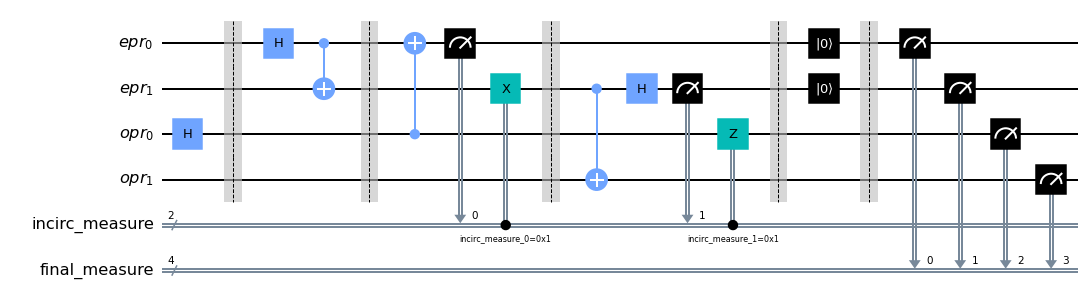

In [24]:
epr_qubits = QuantumRegister(2, "epr")
opr_qubits = QuantumRegister(2, "opr")
measure_bits = ClassicalRegister(2, "incirc_measure")
final_cbits = ClassicalRegister(4, "final_measure")
qc = QuantumCircuit(epr_qubits, opr_qubits, measure_bits, final_cbits)

#check for opr_1 = 1 and opr_2 = 1

qc.h(2)

# qc.x(3)
qc.barrier()

# Generate EPR pair
qc.h(0)
qc.cx(0, 1)
qc.barrier()
# cat entanglement
qc.cx(2,0)
qc.measure(0,0)
qc.x(1).c_if(measure_bits[0], 1)
qc.barrier()
qc.cx(1,3)
qc.h(1)
qc.measure(1,1)
qc.z(2).c_if(measure_bits[1], 1)
qc.barrier()
qc.reset(epr_qubits)

## Measurements
qc.barrier()
qc.measure(epr_qubits, final_cbits[0:2])
qc.measure(opr_qubits, final_cbits[2:4])

qc.draw(output='mpl')

{'00': 10008, '11': 9992}


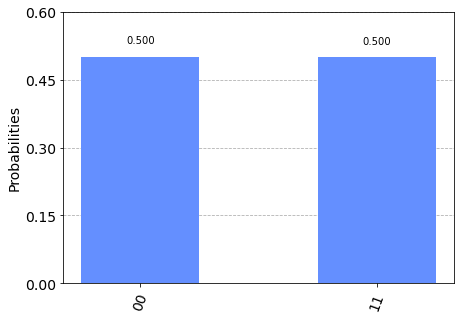

In [25]:
# run circuits on qasm simulator
sim_count = measure_sim(qc=qc)
sim_count = CircuitRemapper.collate_measurements(sim_count, 2)
print(sim_count)
plot_histogram(sim_count)  # Display the output on measurement of state vector

The cat entangling scheme works

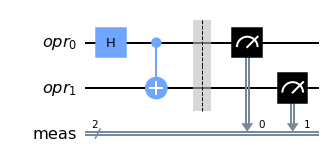

In [26]:
qc = QuantumCircuit(opr_qubits)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
qc.draw(output='mpl')

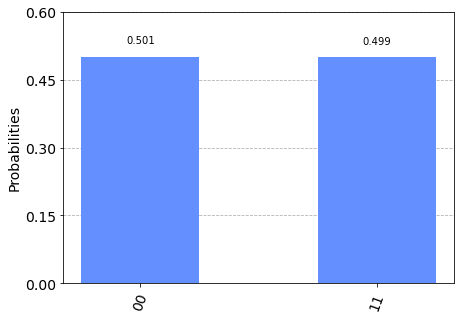

In [27]:
sim_count = measure_sim(qc=qc)
plot_histogram(sim_count)

##### QFT check

In [28]:
def qft_rotations(circuit, n):
    """Add controlled phase gates as per qft on the first n qubits in circuit"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    qft_rotations(circuit, n) # recursion call
    
def swap_registers(circuit, n):
    """Swap Registers as per QFT scheme"""
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit


def qft(circuit, n, transpile_swap = False):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

###### For Four Qubit Topology

In [42]:
circuit_topo = Topology()
circuit_topo.create_qmap(2, [2, 2],"sys")
circuit_topo.qmap, circuit_topo.emap

({'sys0': [Qubit(QuantumRegister(2, 'sys0'), 0),
   Qubit(QuantumRegister(2, 'sys0'), 1)],
  'sys1': [Qubit(QuantumRegister(2, 'sys1'), 0),
   Qubit(QuantumRegister(2, 'sys1'), 1)]},
 {'sys0': Qubit(QuantumRegister(1, 'com_sys0'), 0),
  'sys1': Qubit(QuantumRegister(1, 'com_sys1'), 0)})

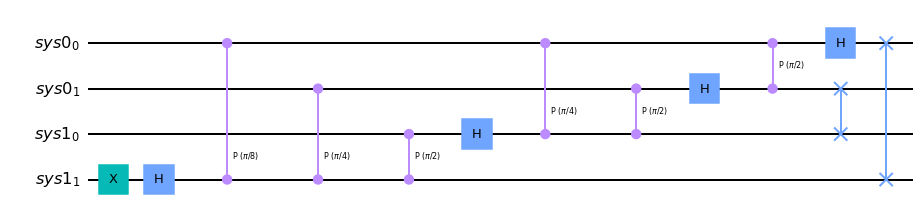

In [43]:
qregs = circuit_topo.get_regs()
n_q = circuit_topo.num_qubits()
circ_1 = QuantumCircuit(*qregs)
circ_1.x(3)
# for i in range(1,n_q):
#     circ_1.h(i)
qft_circ = qft(circ_1, n_q)
qft_circ.draw(output='mpl')

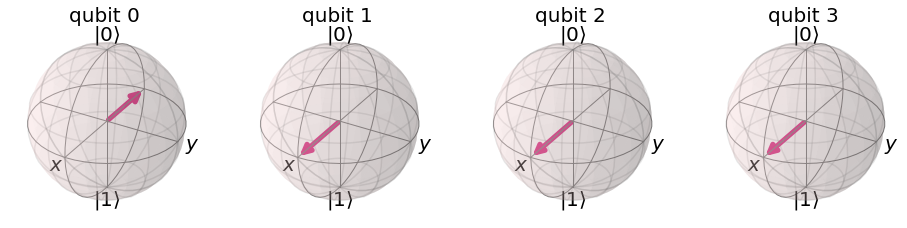

In [44]:
sqc_copy = qft_circ.copy()
sqc_copy.save_statevector()
qobj = assemble(sqc_copy)
state = sim.run(qobj).result().get_statevector()
plot_bloch_multivector(state)

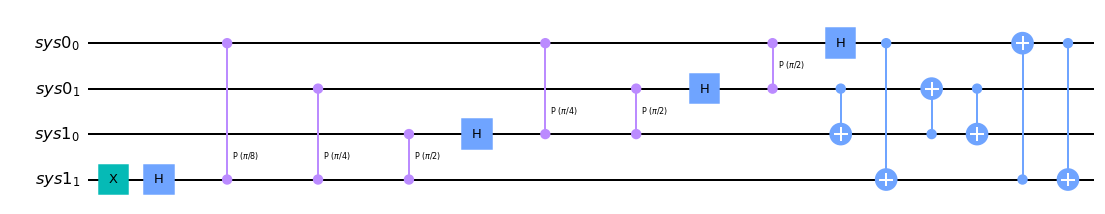

In [45]:
qft_circ.decompose('swap').draw(output='mpl')

In [46]:
remapper = CircuitRemapper(circuit_topo)
dist_circ_1 = remapper.remap_circuit(qft_circ.decompose('swap'))

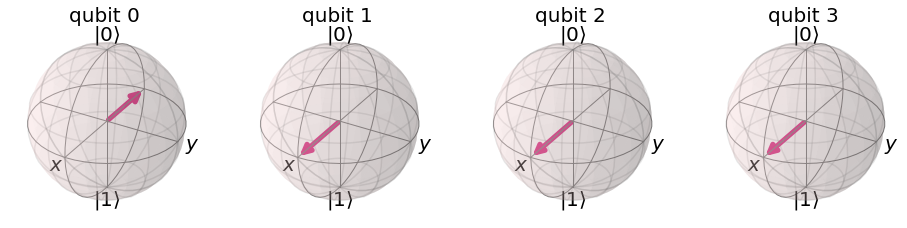

In [47]:
dqc_copy = dist_circ_1.copy()
dqc_copy.save_statevector()
qobj = assemble(dqc_copy)
state = sim.run(qobj).result().get_statevector()

state = partial_trace(state, [4,5])

plot_bloch_multivector(state)

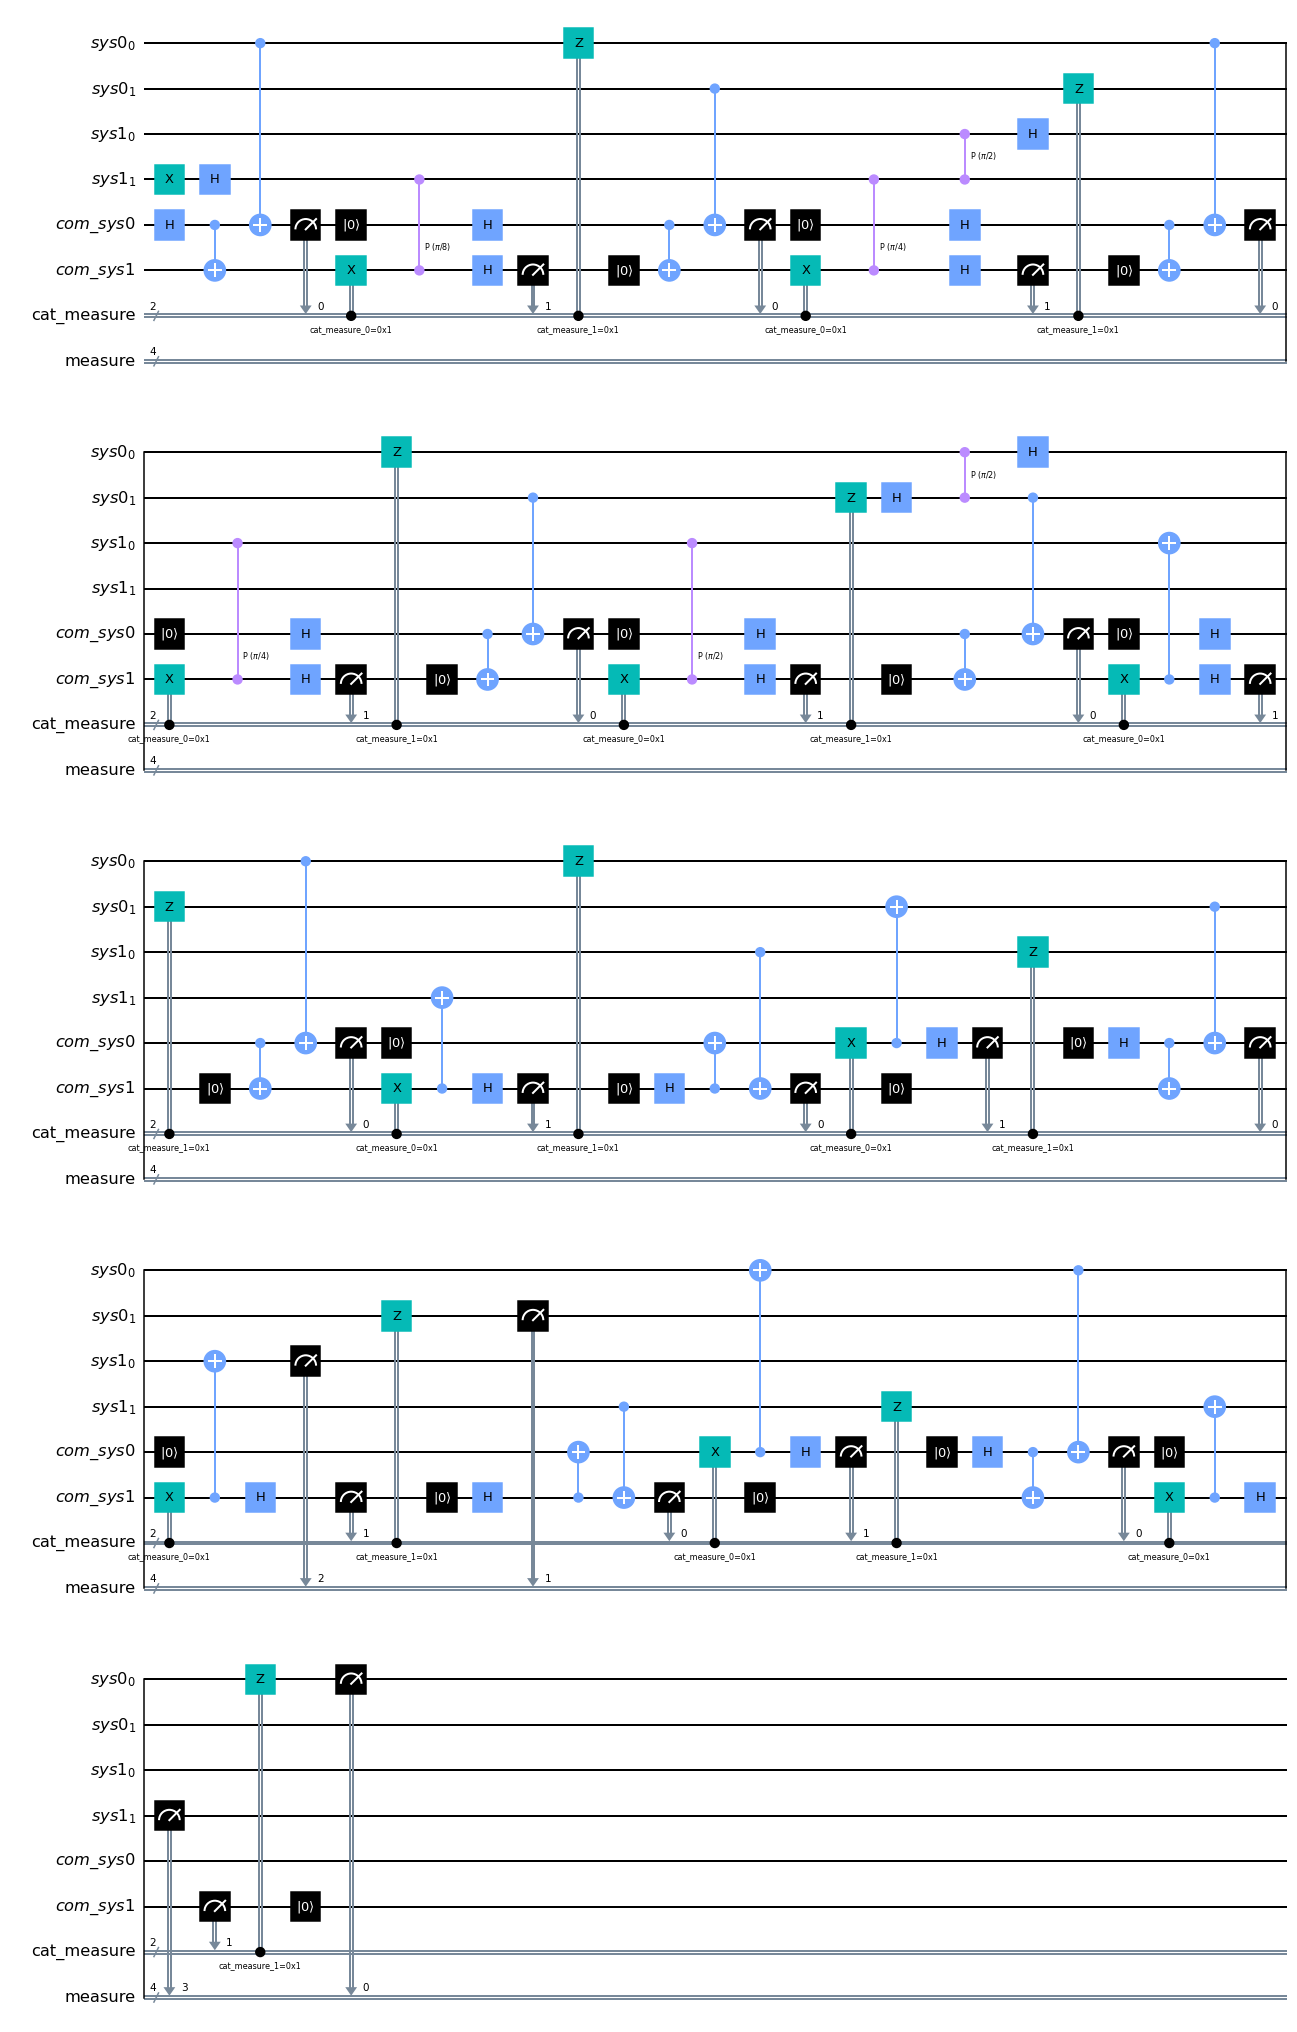

In [48]:
CircuitRemapper.do_measure_ready(dist_circ_1, circuit_topo)
dist_circ_1.draw(output='mpl')

{'0010': 1260, '0111': 1221, '1110': 1239, '1001': 1272, '0001': 1219, '1100': 1223, '1000': 1236, '1101': 1249, '0011': 1254, '1010': 1267, '1011': 1306, '0101': 1242, '0000': 1259, '0110': 1251, '0100': 1282, '1111': 1220}


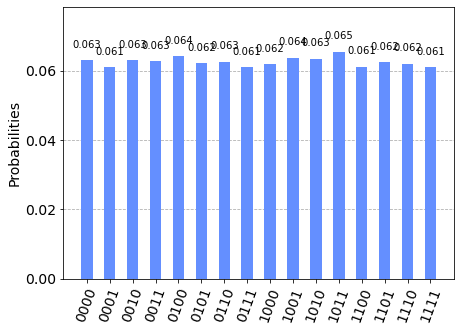

In [49]:
qft_circ.measure_all()
sim_count = measure_sim(qc=qft_circ)
print(sim_count)
plot_histogram(sim_count) 

{'1001': 1254, '0011': 1289, '1111': 1279, '1010': 1293, '0010': 1260, '0110': 1245, '0000': 1265, '1101': 1327, '0111': 1245, '1011': 1226, '1000': 1160, '0101': 1239, '1110': 1198, '0001': 1274, '1100': 1205, '0100': 1241}


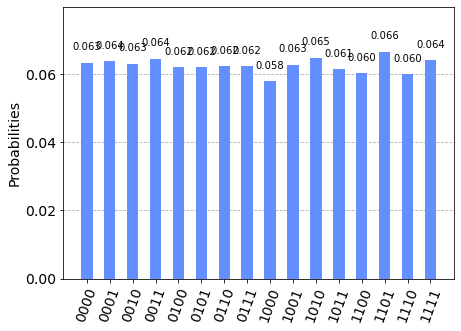

In [50]:
dist_sim_count = measure_sim(qc=dist_circ_1)
sim_dict = CircuitRemapper.collate_measurements(dist_sim_count, n_q)
        
print(sim_dict)
plot_histogram(sim_dict) 

In [51]:
## Assert same binary string values in simulation count dictionary to determine equivalence
assert sim_dict.keys() == sim_count.keys()

###### For 8 Qubit topology

In [61]:
# Define the topology
circuit_topo = Topology()
circuit_topo.create_qmap(4, [2, 2, 3, 1],"sys")
circuit_topo.qmap, circuit_topo.emap

({'sys0': [Qubit(QuantumRegister(2, 'sys0'), 0),
   Qubit(QuantumRegister(2, 'sys0'), 1)],
  'sys1': [Qubit(QuantumRegister(2, 'sys1'), 0),
   Qubit(QuantumRegister(2, 'sys1'), 1)],
  'sys2': [Qubit(QuantumRegister(3, 'sys2'), 0),
   Qubit(QuantumRegister(3, 'sys2'), 1),
   Qubit(QuantumRegister(3, 'sys2'), 2)],
  'sys3': [Qubit(QuantumRegister(1, 'sys3'), 0)]},
 {'sys0': Qubit(QuantumRegister(1, 'com_sys0'), 0),
  'sys1': Qubit(QuantumRegister(1, 'com_sys1'), 0),
  'sys2': Qubit(QuantumRegister(1, 'com_sys2'), 0),
  'sys3': Qubit(QuantumRegister(1, 'com_sys3'), 0)})

In [62]:
qregs = circuit_topo.get_regs()
n_q = circuit_topo.num_qubits()
circ_2 = QuantumCircuit(*qregs, name="QFT")
#QFT of 20
circ_2.x(2)
circ_2.x(4)
# for i in range(1,n_q):
#     circ_2.h(i)
qft_circ2 = qft(circ_2, n_q)

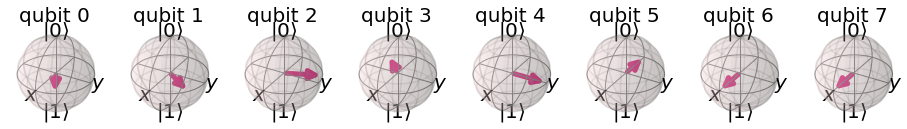

In [63]:
sqc_copy = qft_circ2.copy()
sqc_copy.save_statevector()
qobj = assemble(sqc_copy)
state = sim.run(qobj).result().get_statevector()
plot_bloch_multivector(state)

In [64]:
remapper = CircuitRemapper(circuit_topo)
dist_circ_2 = remapper.remap_circuit(qft_circ2.decompose('swap'))

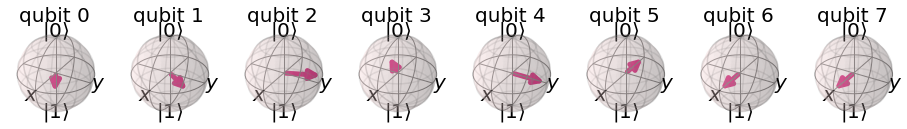

In [65]:
dqc_copy = dist_circ_2.copy()
dqc_copy.save_statevector()
qobj = assemble(dqc_copy)
state = sim.run(qobj).result().get_statevector()

state = partial_trace(state, [8,9,10,11])

plot_bloch_multivector(state)

In [66]:
CircuitRemapper.do_measure_ready(dist_circ_2, circuit_topo)

{'00010011': 81, '00111000': 70, '11111100': 85, '00011111': 69, '00001000': 71, '10100001': 72, '10000110': 72, '01011010': 95, '10110100': 79, '11010111': 75, '00111010': 76, '00100110': 71, '00110100': 91, '00101100': 85, '00000011': 84, '01110111': 87, '01001011': 84, '10010101': 91, '11101010': 63, '11000011': 77, '00110000': 79, '10011111': 81, '10111010': 84, '01010100': 71, '10001100': 68, '00011000': 94, '10100100': 84, '00101000': 64, '11010011': 69, '00100101': 87, '00111011': 67, '01110110': 69, '01001100': 83, '00001100': 83, '00111101': 82, '00100011': 82, '01101010': 76, '01111111': 72, '01000011': 82, '00110010': 74, '00101110': 77, '11011000': 67, '11001001': 92, '10001010': 80, '00011110': 79, '01100000': 83, '10100010': 80, '01111011': 76, '01000111': 73, '11100100': 73, '11001111': 69, '11001100': 70, '11100001': 89, '01000010': 68, '01010000': 75, '10111110': 72, '01101001': 78, '10011000': 68, '01001111': 81, '01110011': 72, '11101110': 69, '11000111': 84, '110011

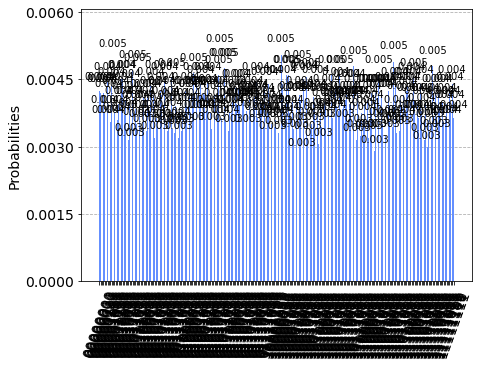

In [67]:
qft_circ2.measure_all()
sim_count = measure_sim(qc=qft_circ2)
print(sim_count)
plot_histogram(sim_count) 

{'11100100': 80, '00011111': 101, '01000001': 58, '00010000': 88, '10101011': 86, '11011011': 85, '01111001': 87, '10000110': 74, '11111110': 85, '10000000': 86, '11001111': 84, '10101101': 80, '11010101': 83, '10111100': 58, '01011011': 66, '01100001': 85, '11000100': 72, '00001011': 78, '10010100': 86, '01101001': 81, '11110111': 77, '01110110': 72, '11110010': 61, '10010010': 86, '10010101': 93, '01101000': 83, '11011110': 76, '10010000': 69, '11110000': 72, '00001001': 66, '00001111': 89, '11001110': 79, '11000001': 79, '10110110': 70, '00100101': 93, '01000111': 81, '00001100': 80, '10001000': 83, '11001011': 74, '11111000': 84, '10111011': 66, '00001010': 90, '00001101': 72, '00000000': 85, '10101110': 86, '11010001': 72, '11010110': 81, '10110001': 62, '00101010': 94, '01001111': 75, '01010100': 73, '10011000': 60, '10111111': 80, '01011001': 80, '11000111': 76, '01100011': 83, '00011110': 75, '01000110': 80, '10000111': 82, '11111111': 74, '11110011': 96, '10010011': 74, '10110

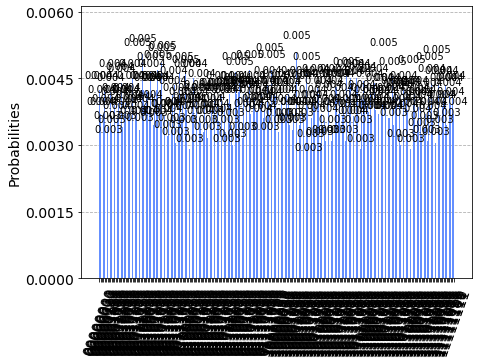

In [68]:
dist_sim_count = measure_sim(qc=dist_circ_2)
sim_dict = CircuitRemapper.collate_measurements(dist_sim_count, n_q)
        
print(sim_dict)
plot_histogram(sim_dict) 

In [69]:
## Assert same binary string values in simulation count dictionary to determine equivalence
assert sim_dict.keys() == sim_count.keys()

##### Check Decomposition

In [10]:
circuit_topo = Topology()
circuit_topo.create_qmap(3, [2, 3, 3],"sys")
circuit_topo.qmap, circuit_topo.emap

({'sys0': [Qubit(QuantumRegister(2, 'sys0'), 0),
   Qubit(QuantumRegister(2, 'sys0'), 1)],
  'sys1': [Qubit(QuantumRegister(3, 'sys1'), 0),
   Qubit(QuantumRegister(3, 'sys1'), 1),
   Qubit(QuantumRegister(3, 'sys1'), 2)],
  'sys2': [Qubit(QuantumRegister(3, 'sys2'), 0),
   Qubit(QuantumRegister(3, 'sys2'), 1),
   Qubit(QuantumRegister(3, 'sys2'), 2)]},
 {'sys0': Qubit(QuantumRegister(1, 'com_sys0'), 0),
  'sys1': Qubit(QuantumRegister(1, 'com_sys1'), 0),
  'sys2': Qubit(QuantumRegister(1, 'com_sys2'), 0)})

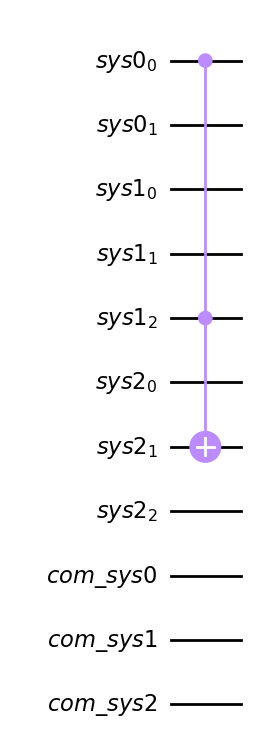

In [11]:
qregs = circuit_topo.get_regs()
qc = QuantumCircuit(*qregs)
qc.ccx(0, 4, 6)
qc.draw('mpl')

In [12]:
circ_object = CircuitRemapper(circuit_topo)
dist_circ = circ_object.remap_circuit(qc)
dist_circ.draw(output='mpl')

CircuitError: 'The circuit contains incompatible gates, Please try decompose=True keyword argument.'

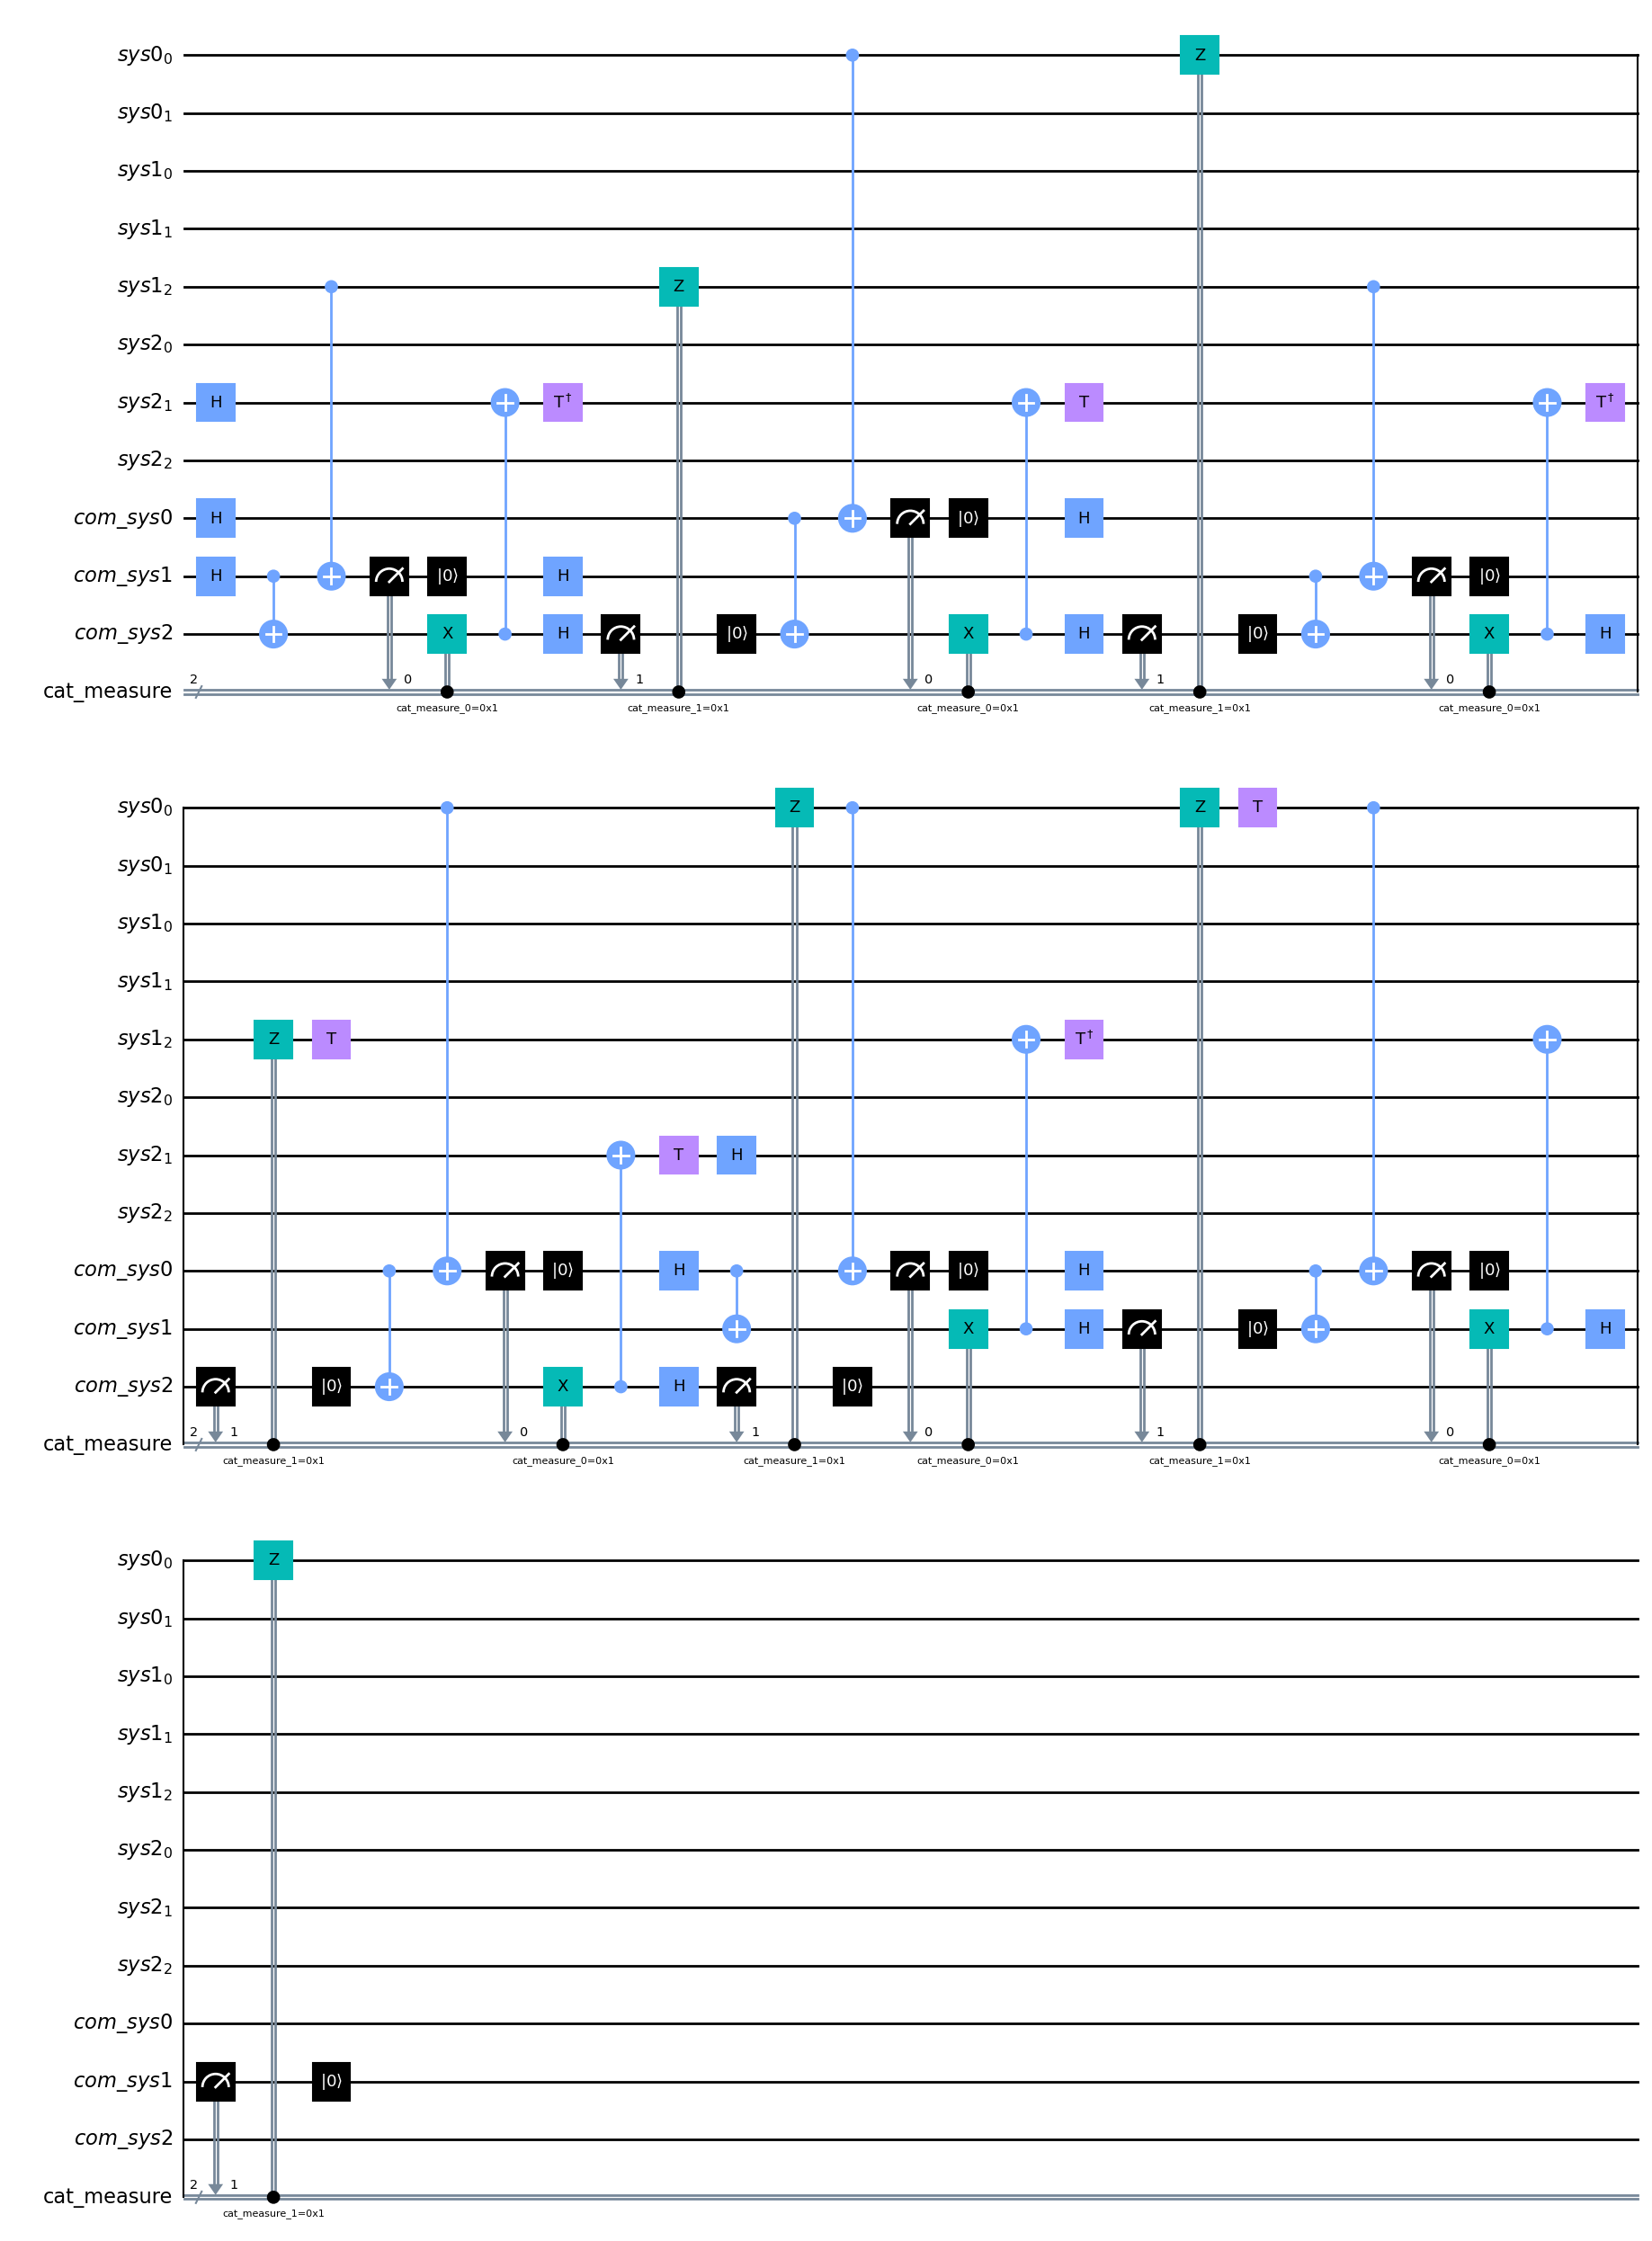

In [13]:
dist_circ = circ_object.remap_circuit(qc, decompose=True)
dist_circ.draw(output='mpl')